# Analyse peak enrichment scores

## 1. Set up the notebook

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy.sparse import csr_matrix
from matplotlib.pyplot import rcParams
from itertools import combinations, chain
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary, load_sparse_h5

rcParams["figure.figsize"] = 15, 10

In [2]:
os.chdir("../data/processed/")

In [3]:
def binarize(X, t):
    X = X.copy()
    condition = X.data >= t
    X.data[condition] = 1
    X.data[np.logical_not(condition)] = 0
    return X

## 2. Load the data

UMAP for visualization

In [4]:
UMAP = np.load("greenleaf_scATAC_filtered_umap.npy")

Load the peak matrix

In [5]:
fname = "greenleaf_scATAC_peaks_filtered.h5"
X = load_sparse_h5("scATAC", fname)

Binarize the counts for visualization

In [6]:
X = binarize(X, 1)

In [7]:
with open("greenleaf_scATAC_peaks_filtered.txt", "r") as f:
    peaks = [g.strip("\n") for g in f.readlines()]
f.close()

Load the selected cells

In [8]:
fname = "greenleaf_scATAC_cells_selected_from_knn.txt"
with open(fname, "r") as f:
    r_cells = [int(c.strip("\n")) for c in f.readlines()]
f.close()

Load the enrichment scores and concat the frames

In [9]:
escores = []
for sub in ["common", "medium", "rare"]:
    s = pd.read_csv(f"greenleaf_scATAC_escores_knn_rbf_8e-1_{sub}.txt",
                    sep="\t", index_col=0)
    escores.append(s)
escores = pd.concat(escores)

Load the null-distribution scores and concat the frames

In [10]:
os.chdir("../interim/")

In [11]:
pscores = []
for sub in ["common", "medium", "rare"]:
    s = pd.read_csv(f"greenleaf_scATAC_pscores_knn_rbf_8e-1_{sub}.txt",
                    sep="\t", index_col=0)
    pscores.append(s)
pscores = pd.concat(pscores)

## 3. Get significant peaks

Determine the interval

In [12]:
cutoffs = sig_interval(pscores, n_sds=20)

Get a dictionary of signficant peaks per cell

In [13]:
sigdict = sig_dictionary(escores, cutoffs)

## 4. Get BED-files for GREAT
We use the significantly enriched peaks with positive enrichment scores to use externally in GREAT for cell annotation

In [14]:
os.chdir("../processed")

In [15]:
positives = sig_dictionary(escores, cutoffs, sign="positive")

We save a bed file per reference cell

In [16]:
for k, v in positives.items():
    sigs = pd.DataFrame([p.split("_") for p in v])
    sigs.to_csv(f"GREAT/{k}_possigs.bed", sep="\t", index=None, header=None)

We create a background file

In [17]:
peakbed = [p.split("_") for p in peaks]
peakbed = pd.DataFrame(peakbed)
peakbed.to_csv(f"GREAT/background.bed", sep="\t", index=None, header=None)

GREAT using 100bp upstream, 1000bp downstream, and 1000kb proximal

## 5. Visualize the annotations

In [18]:
os.chdir("../processed/")

In [19]:
A = pd.read_csv("greenleaf_scATAC_knn_rbf_8e1_annotations.csv", sep="\t")

In [20]:
params = {"mathtext.default": "regular"}
order = ["HSC", "MPP", "CMP",
         "MEP", "ERYTHROCYTE",
         "GMP", "GP", "BASO",
         "MP", "MONO", "MONO_CLAS", "MONO_INT", "MoDC",
         "CLP", "PRE_B", "B_TRANSITIONAL", "B_NAIVE", "B_MEMORY", "PLASMA",
         "CD4_NAIVE", "CD4_MEMORY", "CD8_MAIT",
         "CD8_EFFECTOR_MEMORY", "CD8_TERM_EFFECT",
         "NK", "preDC", "pDC", "UNK"]
labels = ["HSC", "MPP",
          "CMP", "MEP", "Erythrocytes",
          "GMP", "GP", "Basophils",
          "MP", "Monocyte", "Classical monocyte", "Intermediate monocyte",
          "MoDC",
          "CLP", "Pre-B", "Transitional B", "Naive B", "B memory", "Plasma",
          r"Naive CD4$^{+}$", r"CD4$^{+}$ memory",
          r"CD8$^{+}$ MAIT", r"CD8$^{+}_{EM}$",
          r"CD8$^{+}_{TE}$", "NK", "preDC", "pDC", "Unknown"]
annots = pd.read_csv("greenleaf_scATAC_knn_rbf_8e1_annotations.csv", sep="\t")
annots = annots.replace(dict(zip(order, labels)))
order = labels
colors = list(annots.COLOUR)
labels = annots.ANNOT
ids = [int(i) for i in annots.ID]

coldict = dict(zip(annots.ANNOT, annots.COLOUR))
legend = {k: coldict[k] for k in order}
marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="", markersize=2)
          for c in legend.values()]

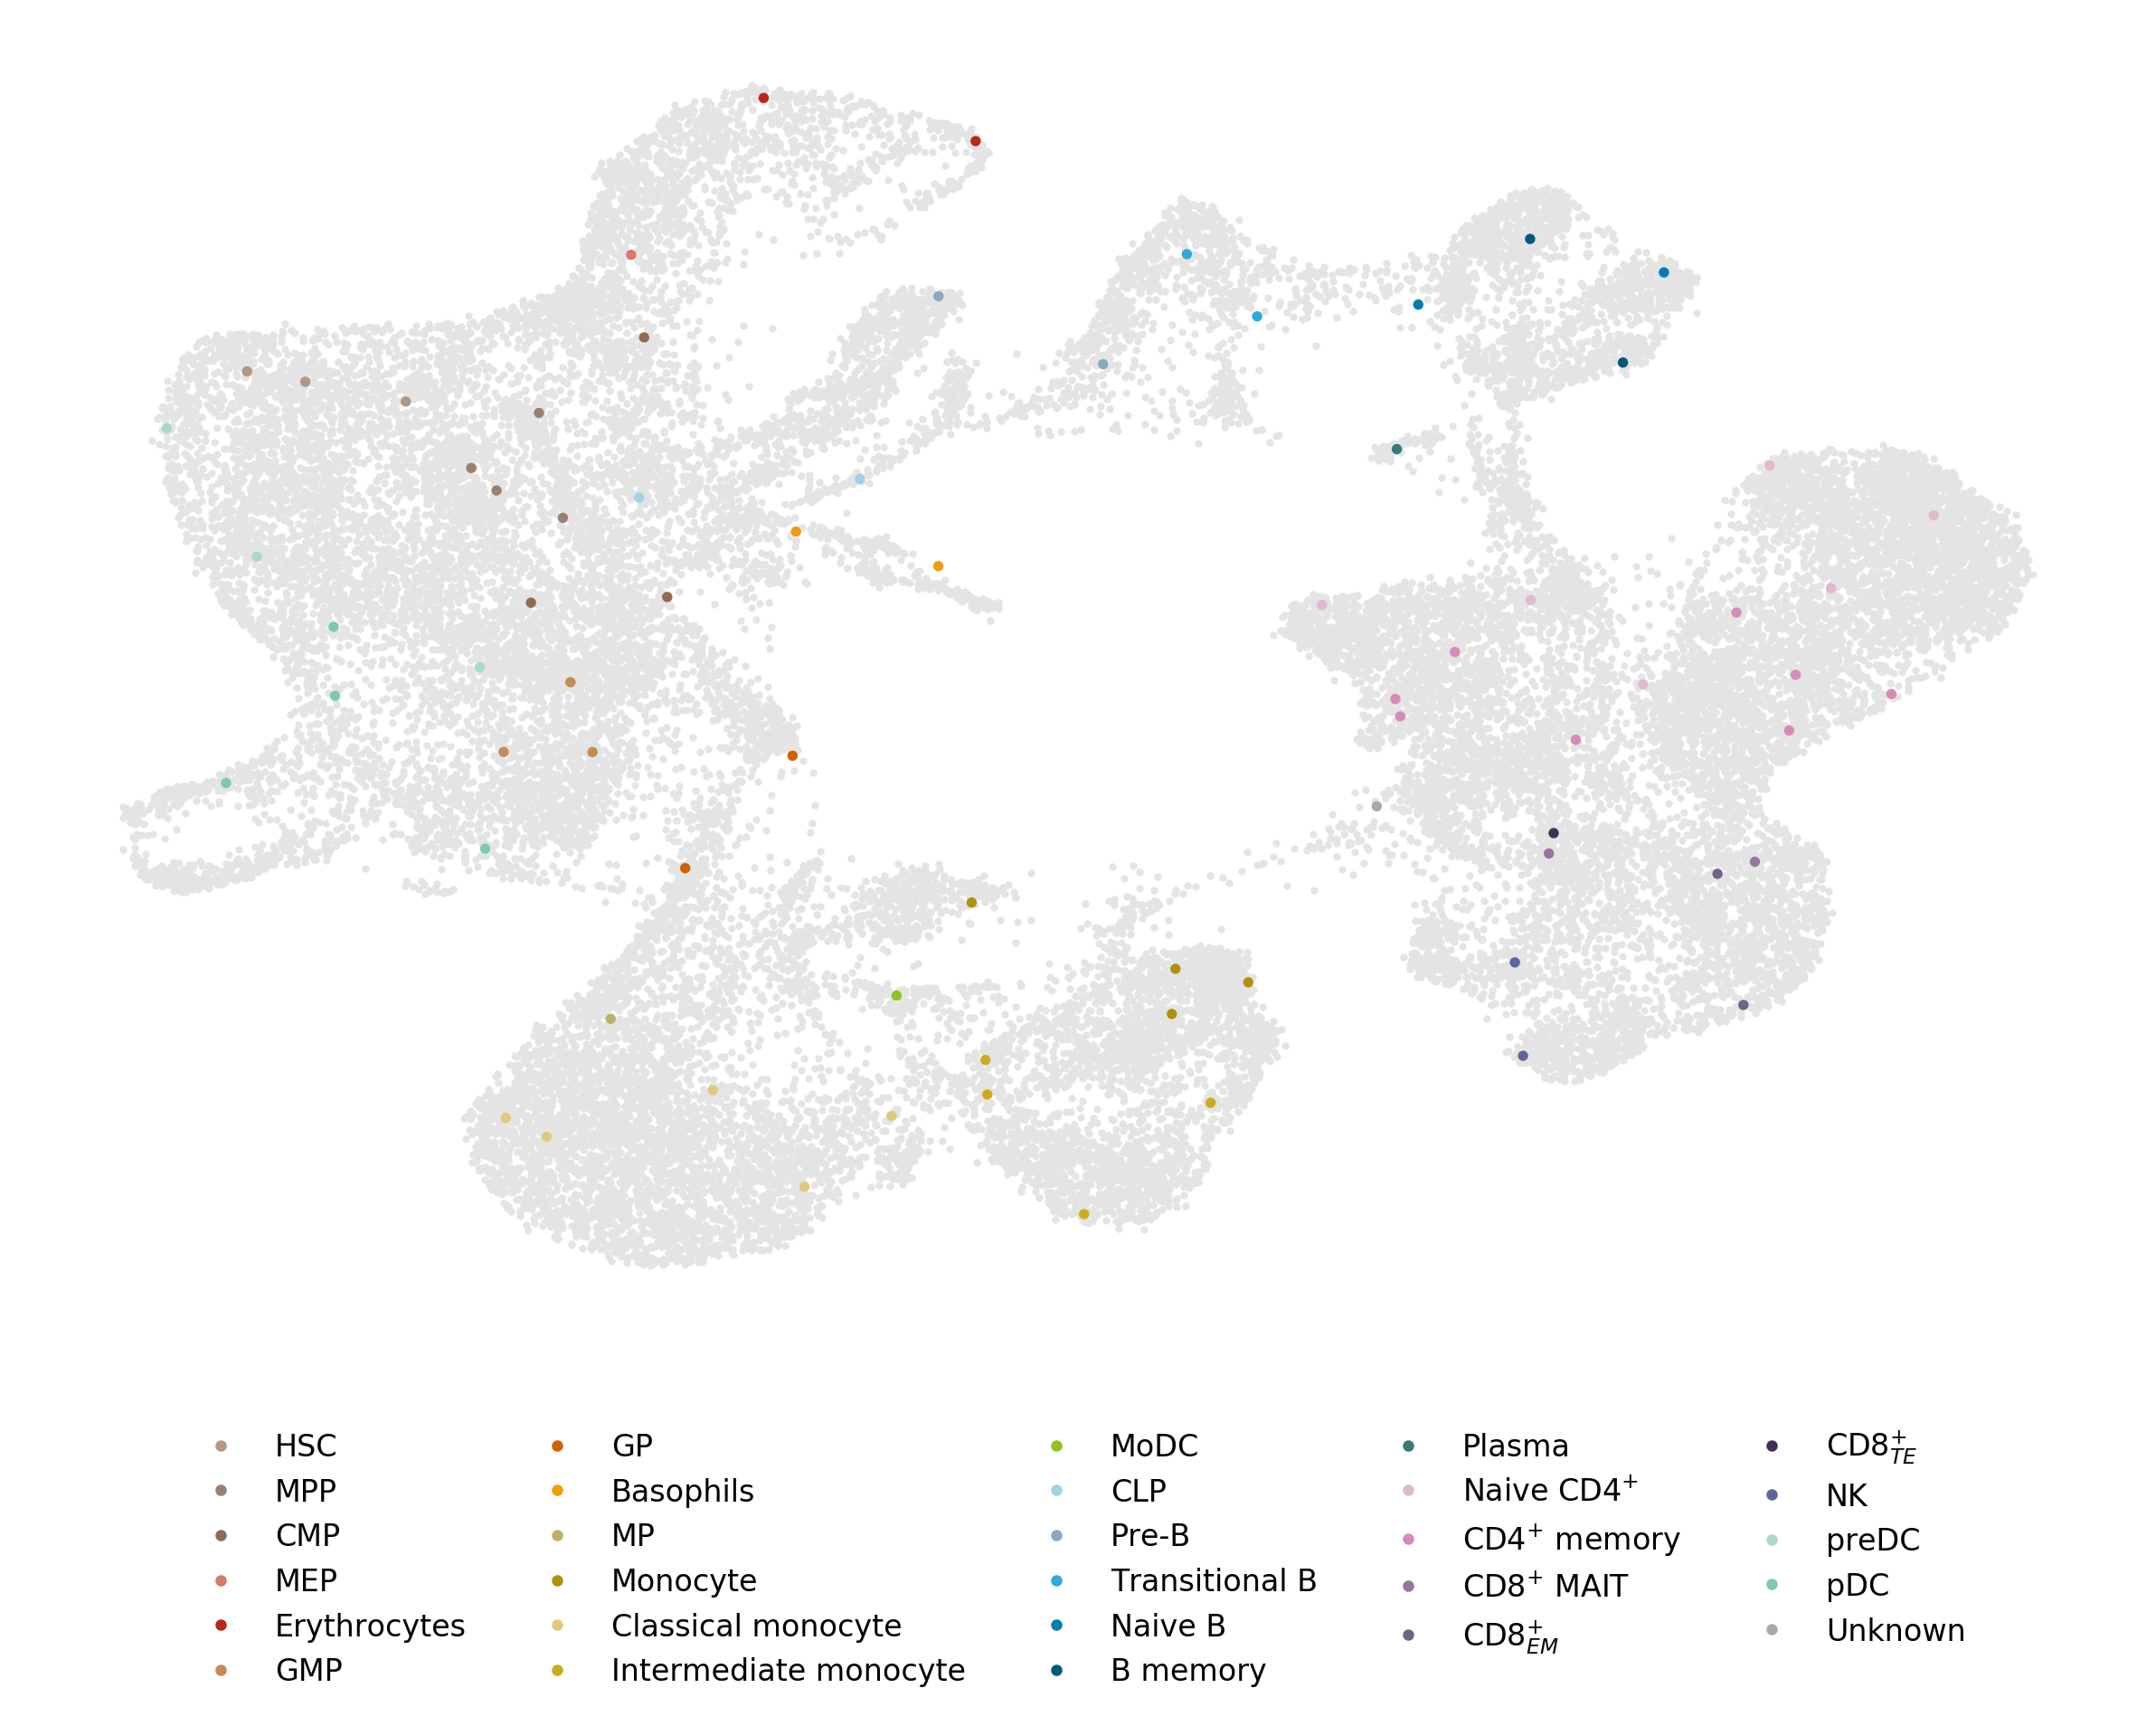

In [21]:
plt.figure(figsize=(8.27, 6.5), dpi=300)
plt.scatter(UMAP[:, 0], UMAP[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP[A.ID, 0], UMAP[A.ID, 1], c=A.COLOUR.values, s=3)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=8, ncol=5,
                 loc="lower center", bbox_to_anchor=(0.5, -0.3))
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

## 6. Load the HOMER and FANTOM5 data

Get the HOMER annotations as obtained for the background bed file

In [22]:
HOMER = pd.read_csv("greenleaf_scATAC_peak_annotations_HOMER.txt", sep="\t")
HOMER.Start = HOMER.Start - 1
HOMER.index = HOMER["Chr"] + "_" + HOMER["Start"].astype(str) + "_" + HOMER["End"].astype(str)
columns = ["Annotation", "Detailed Annotation", "Distance to TSS",
           "Nearest PromoterID", "Gene Name"]
HOMER = HOMER[columns]
newcols = ["annotation", "detailed", "TSS_dist", "promoter", "gene"]
HOMER = HOMER.rename(columns=dict(zip(columns, newcols)))
# we replace the annotations with python readable annotations
annotations = HOMER.annotation
annotations = ["intron" if "intron" in r else r for r in annotations]
annotations = ["promoter" if "promoter-TSS" in r else r for r in annotations]
annotations = ["non_coding" if "non-coding" in r else r for r in annotations]
annotations = ["3'UTR" if "3' UTR" in r else r for r in annotations]
annotations = ["5'UTR" if "5' UTR" in r else r for r in annotations]
annotations = ["intergenic" if "Intergenic" in r else r for r in annotations]
annotations = ["TTS" if "TTS" in r else r for r in annotations]
annotations = ["exon" if "exon" in r else r for r in annotations]
HOMER.annotation = annotations

Get the peaks that overlap FANTOM5 annotated enhancers

In [23]:
FANTOM5 = pd.read_csv("greenleaf_scATAC_FANTOM5_enhancer_peaks.txt", sep="\t",
                      header=None)
FANTOM5 = FANTOM5[0] + "_" + FANTOM5[1].astype(str) + "_" + FANTOM5[2].astype(str)
enhancers = np.where(np.isin(list(HOMER.index), list(FANTOM5)))[0]
enhancers = [x for x in enhancers if not HOMER.annotation[x] == "promoter"]
HOMER.iloc[enhancers, 0] = "enhancer"

Check how many regions have a certain annotation

In [24]:
ns = {}
for i in np.unique(HOMER.annotation):
    n = len(HOMER[HOMER.annotation == i])
    ns[i] = n
    print(f"{n} {i} annotations")
ns = pd.DataFrame(ns, index=["n"])
ns = ns[["promoter", "enhancer", "intergenic", "intron", "exon",
         "3'UTR", "5'UTR", "TTS", "non_coding"]]

7052 3'UTR annotations
1676 5'UTR annotations
8945 TTS annotations
35827 enhancer annotations
11372 exon annotations
142404 intergenic annotations
208256 intron annotations
4220 non_coding annotations
31728 promoter annotations


Enrichment per annotations

Get a list of negatively erniched genes

In [25]:
negatives = sig_dictionary(escores, cutoffs, sign="negative")

Get the percentage of annotations for all signficant regions

In [26]:
# explore total proportions within signficant regions
pcnt_sig = {}
for i in np.unique(HOMER.annotation):
    pcnt_sig[i] = []
    for c, v in sigdict.items():
        if not len(v) == 0:
            n = len(HOMER.loc[v, :][HOMER.loc[v, :].annotation == i])
            p = n / len(HOMER.loc[v, :]) * 100
            pcnt_sig[i].append(p)
        else:
            continue
pcnt_sig = pd.DataFrame(pcnt_sig).T
pcnt_sig = pcnt_sig.reindex(["promoter", "enhancer", "intergenic", "intron",
                             "exon", "3'UTR", "5'UTR", "TTS", "non_coding"])

In [27]:
# explore total proportions within signficant regions
pcnt_pos = {}
for i in np.unique(HOMER.annotation):
    pcnt_pos[i] = []
    for c, v in positives.items():
        if not len(v) == 0:
            n = len(HOMER.loc[v, :][HOMER.loc[v, :].annotation == i])
            p = n / len(HOMER.loc[v, :]) * 100
            pcnt_pos[i].append(p)
        else:
            continue
pcnt_pos = pd.DataFrame(pcnt_pos).T
pcnt_pos = pcnt_pos.reindex(["promoter", "enhancer", "intergenic", "intron",
                       "exon", "3'UTR", "5'UTR", "TTS", "non_coding"])

In [28]:
# explore total proportions within signficant regions
pcnt_neg = {}
for i in np.unique(HOMER.annotation):
    pcnt_neg[i] = []
    for c, v in negatives.items():
        if not len(v) == 0:
            n = len(HOMER.loc[v, :][HOMER.loc[v, :].annotation == i])
            p = n / len(HOMER.loc[v, :]) * 100
            pcnt_neg[i].append(p)
        else:
            continue
pcnt_neg = pd.DataFrame(pcnt_neg).T
pcnt_neg = pcnt_neg.reindex(["promoter", "enhancer", "intergenic", "intron",
                       "exon", "3'UTR", "5'UTR", "TTS", "non_coding"])

Visualize the percentage of peaks that have a certain annotation

In [29]:
def set_box_color(bp, color):
    plt.setp(bp["medians"], color=color)
    plt.setp(bp["boxes"], color="grey")
    plt.setp(bp["whiskers"], color="grey")
    plt.setp(bp["caps"], color="grey")
    plt.setp(bp["fliers"], color=color)

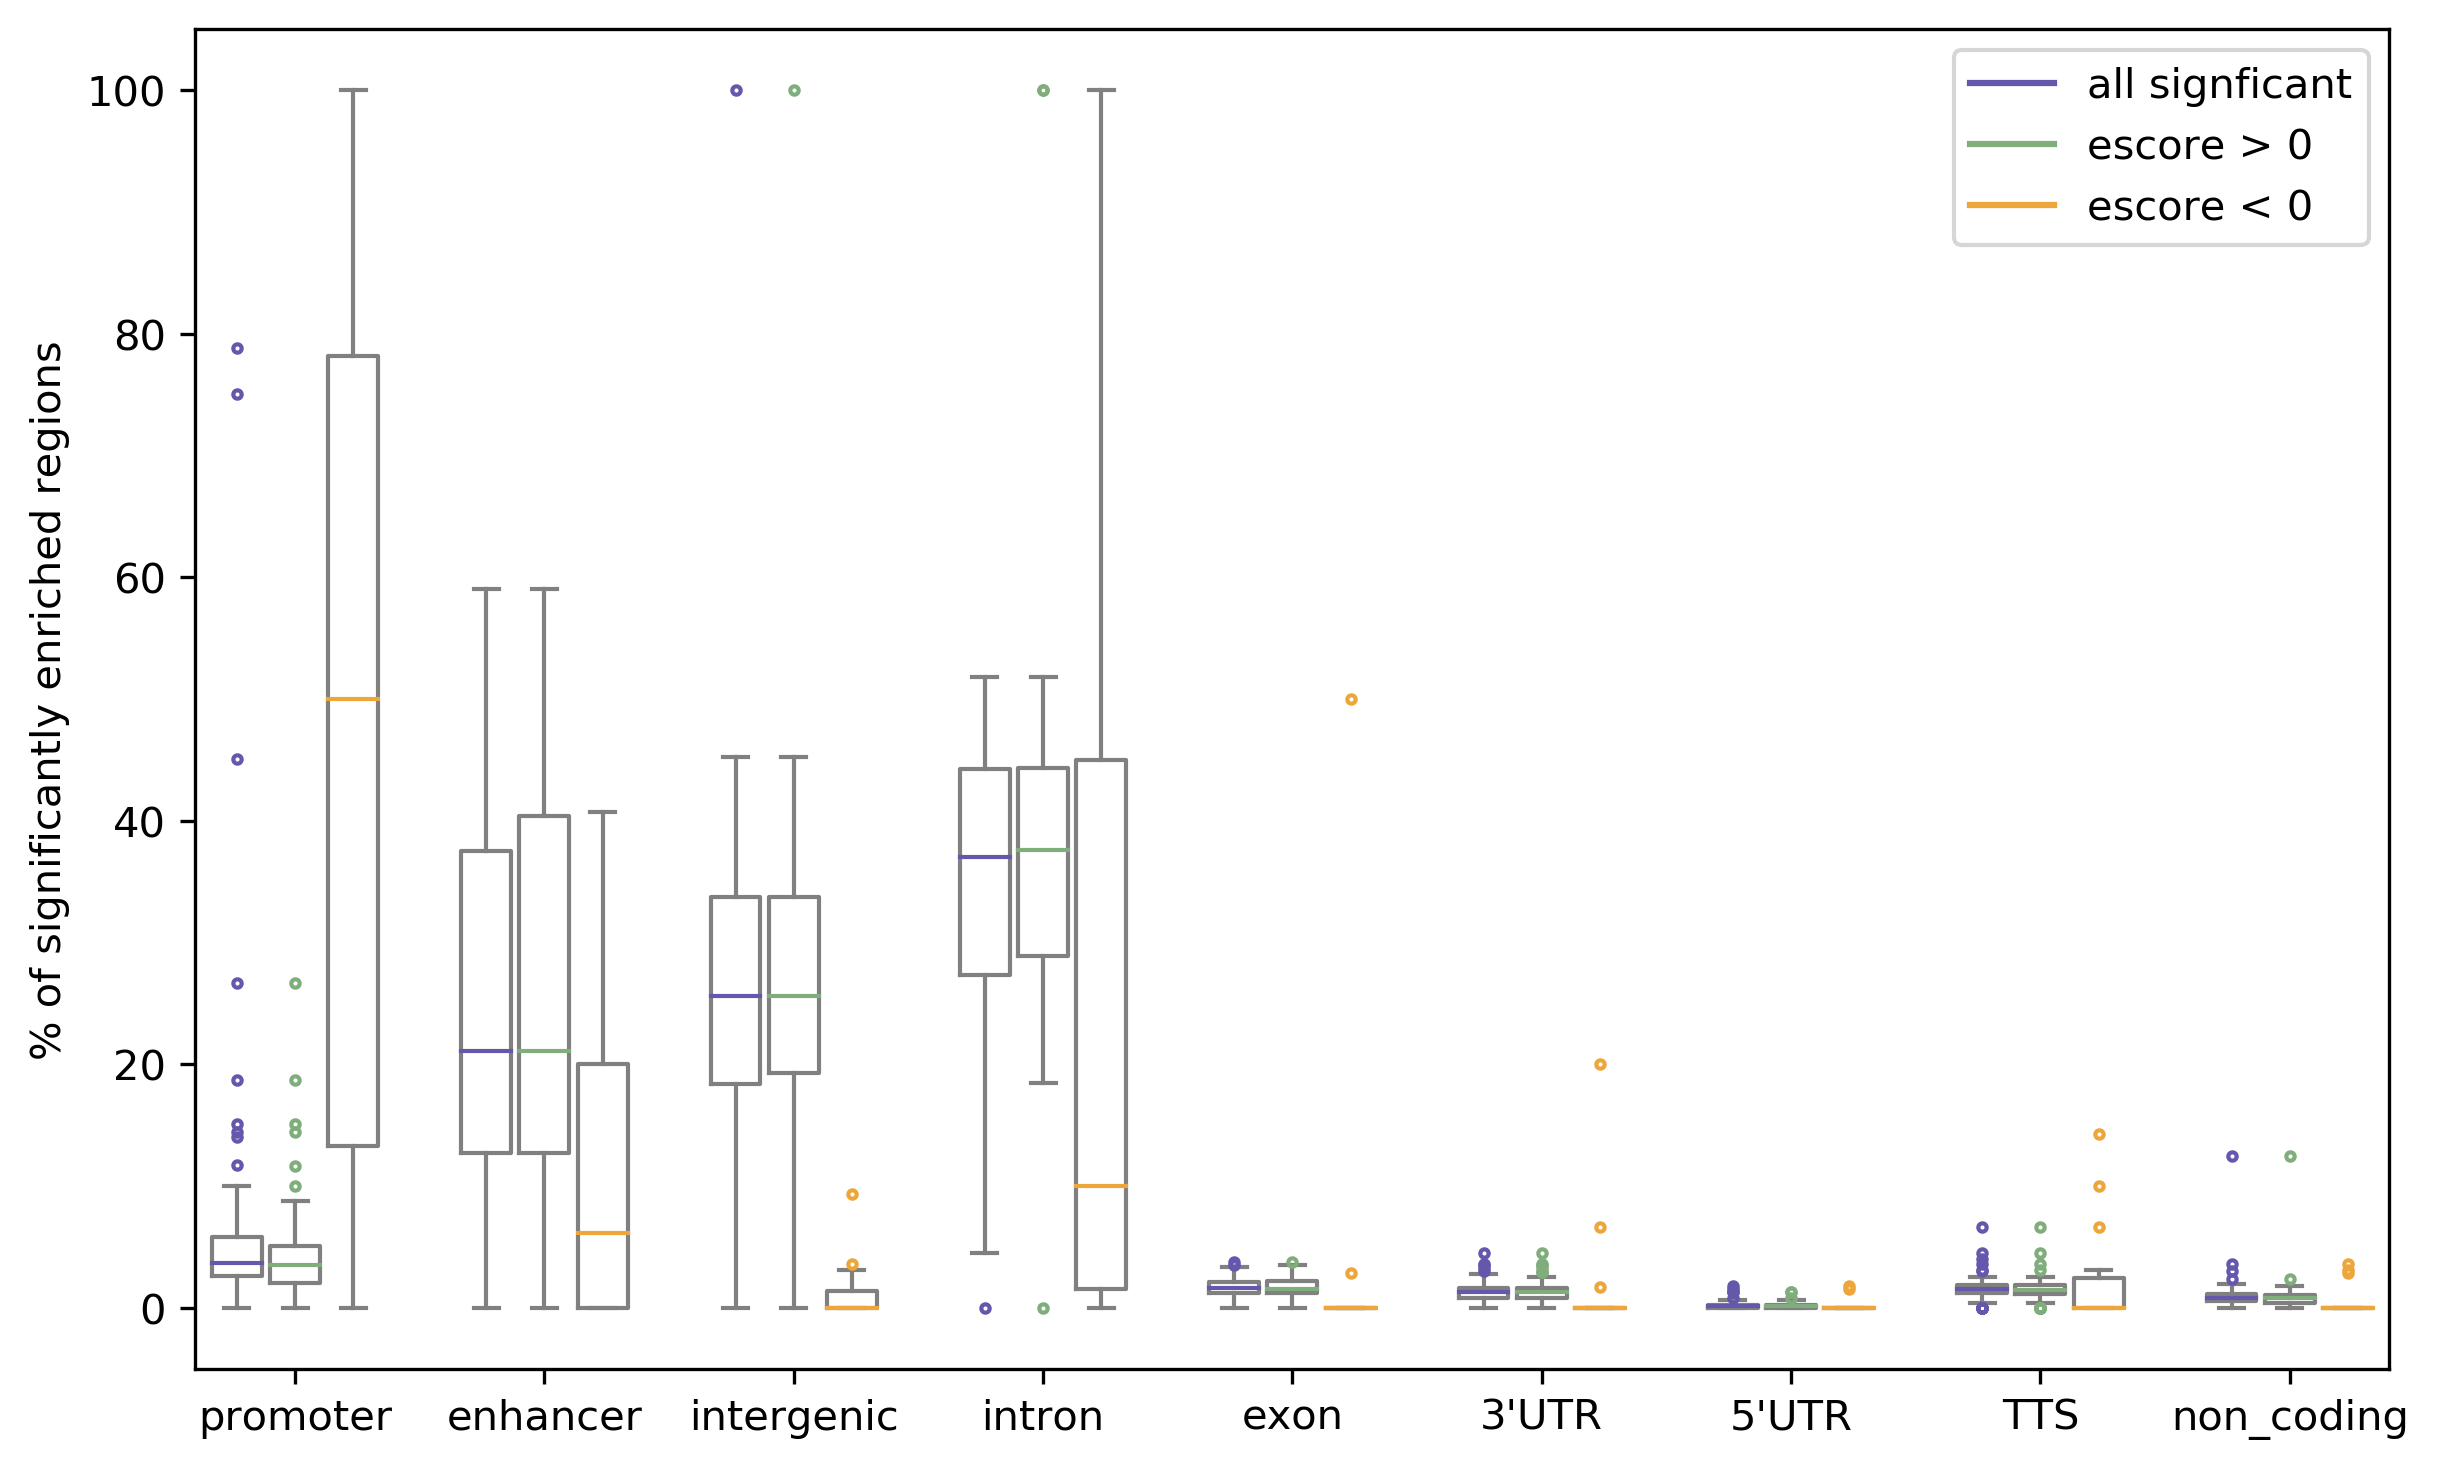

In [30]:
# define colours
c1 = "#6458ad"
c2 = "#7fad7b"
c3 = "#eca639"
    
plt.figure(figsize=(8.27, 5), dpi=300)

# plot boxplot
obp = plt.boxplot(pcnt_sig, positions=np.array(range(len(pcnt_pos))) * 3.0 - 0.7,
                  widths=0.6, flierprops={"markeredgecolor": c1,
                                          "markersize": 2})
pbp = plt.boxplot(pcnt_pos, positions=np.array(range(len(pcnt_pos))) * 3.0,
                  widths=0.6, flierprops={"markeredgecolor": c2,
                                          "markersize": 2})
nbp = plt.boxplot(pcnt_neg, positions=np.array(range(len(pcnt_neg))) * 3.0 + 0.7,
                  widths=0.6, flierprops={"markeredgecolor": c3,
                                          "markersize": 2})

# change colours
set_box_color(obp, c1)
set_box_color(pbp, c2)
set_box_color(nbp, c3)

# legend
plt.plot([], c=c1, label="all signficant")
plt.plot([], c=c2, label="escore > 0")
plt.plot([], c=c3, label="escore < 0")
plt.legend()

plt.ylabel("% of significantly enriched regions")
plt.xticks(np.array(range(len(pcnt_pos))) * 3.0, labels=pcnt_sig.index)
plt.tight_layout()

Normalize the percentages for the total number of peaks that have a specific annotation

In [31]:
ns = ns / np.sum(ns.values) * 100

Visualize the normalized percentages

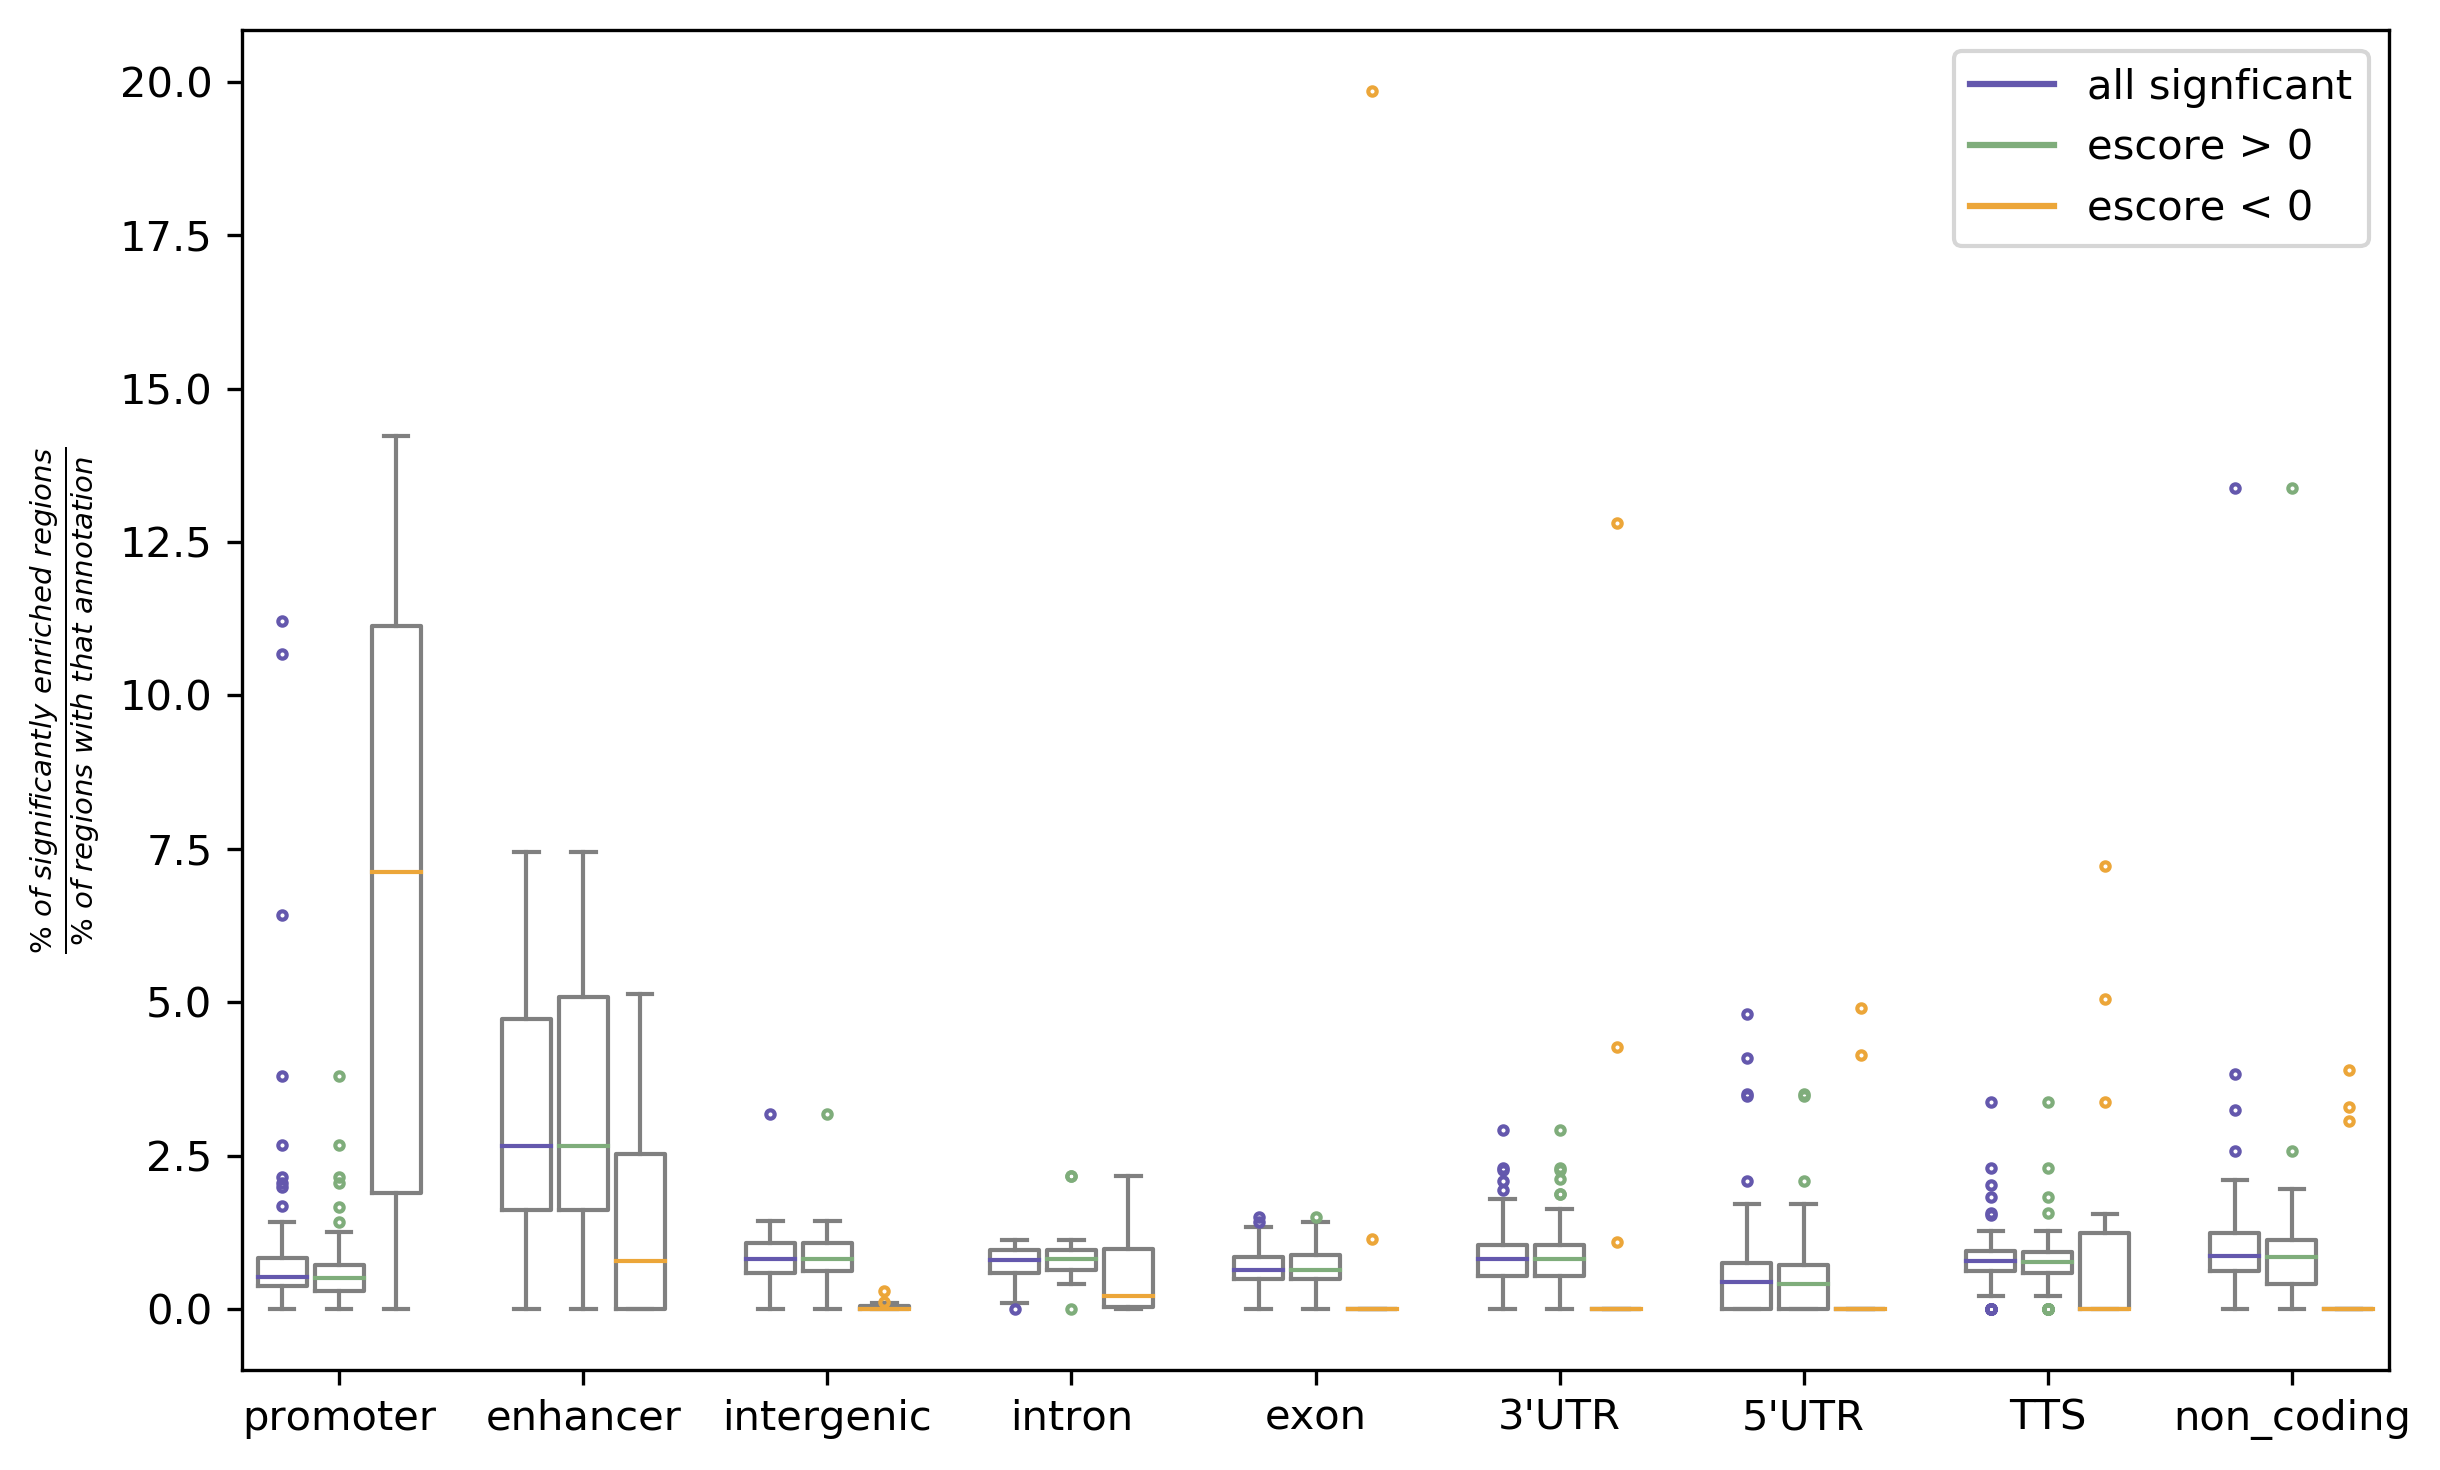

In [32]:
# define colours
c1 = "#6458ad"
c2 = "#7fad7b"
c3 = "#eca639"
    
plt.figure(figsize=(8.27, 5), dpi=300)

# plot boxplot
obp = plt.boxplot(pcnt_sig / ns.T.values, positions=np.array(range(len(pcnt_pos))) * 3.0 - 0.7,
                  widths=0.6, flierprops={"markeredgecolor": c1,
                                          "markersize": 2})
pbp = plt.boxplot(pcnt_pos / ns.T.values, positions=np.array(range(len(pcnt_pos))) * 3.0,
                  widths=0.6, flierprops={"markeredgecolor": c2,
                                          "markersize": 2})
nbp = plt.boxplot(pcnt_neg / ns.T.values, positions=np.array(range(len(pcnt_neg))) * 3.0 + 0.7,
                  widths=0.6, flierprops={"markeredgecolor": c3,
                                          "markersize": 2})

# change colours
set_box_color(obp, c1)
set_box_color(pbp, c2)
set_box_color(nbp, c3)

# legend
plt.plot([], c=c1, label="all signficant")
plt.plot([], c=c2, label="escore > 0")
plt.plot([], c=c3, label="escore < 0")
plt.legend()

plt.ylabel(r"$\frac{\%\ of\ significantly\ enriched\ regions}{\%\ of\ regions\ with\ that\ annotation}$")
plt.xticks(np.array(range(len(pcnt_pos))) * 3.0, labels=pcnt_sig.index)
plt.tight_layout()

Visualize the percent of significantly enriched enhancers and promoters per cell annotation

In [33]:
order = ["HSC", "MPP",
         "CLP", "CMP",
         "MEP", "GMP",
         "GP", "MP", "PRE_B", "preDC", "B_TRANSITIONAL",
         "ERYTHROCYTE", "BASO",
         "MONO", "MONO_CLAS", "MONO_INT", "MoDC",
         "B_NAIVE", "B_MEMORY", "PLASMA",
         "CD4_NAIVE", "CD4_MEMORY", "CD8_MAIT",
         "CD8_EFFECTOR_MEMORY", "CD8_TERM_EFFECT",
         "NK", "pDC"]

Load the annotations

In [34]:
A = pd.read_csv("../processed/greenleaf_scATAC_knn_rbf_8e1_annotations.csv", sep="\t")

In [35]:
cols = [k for k in positives.keys() if len(positives[k]) > 0]

Get the precentages of promoters and enhancers

In [36]:
pcnt_pos.columns = cols
pcnt_pos_prom = {}
pcnt_pos_enh = {}
for a in order:
    newa = A[A.ID.isin(cols)]
    ids = newa[newa.ANNOT == a].ID
    ids = [str(k) for k in ids]
    n = pcnt_pos.loc["promoter", ids]
    pcnt_pos_prom[a] = n.values
    n = pcnt_pos.loc["enhancer", ids]
    pcnt_pos_enh[a] = n.values

Visualize the percent of promoters per cell annotation

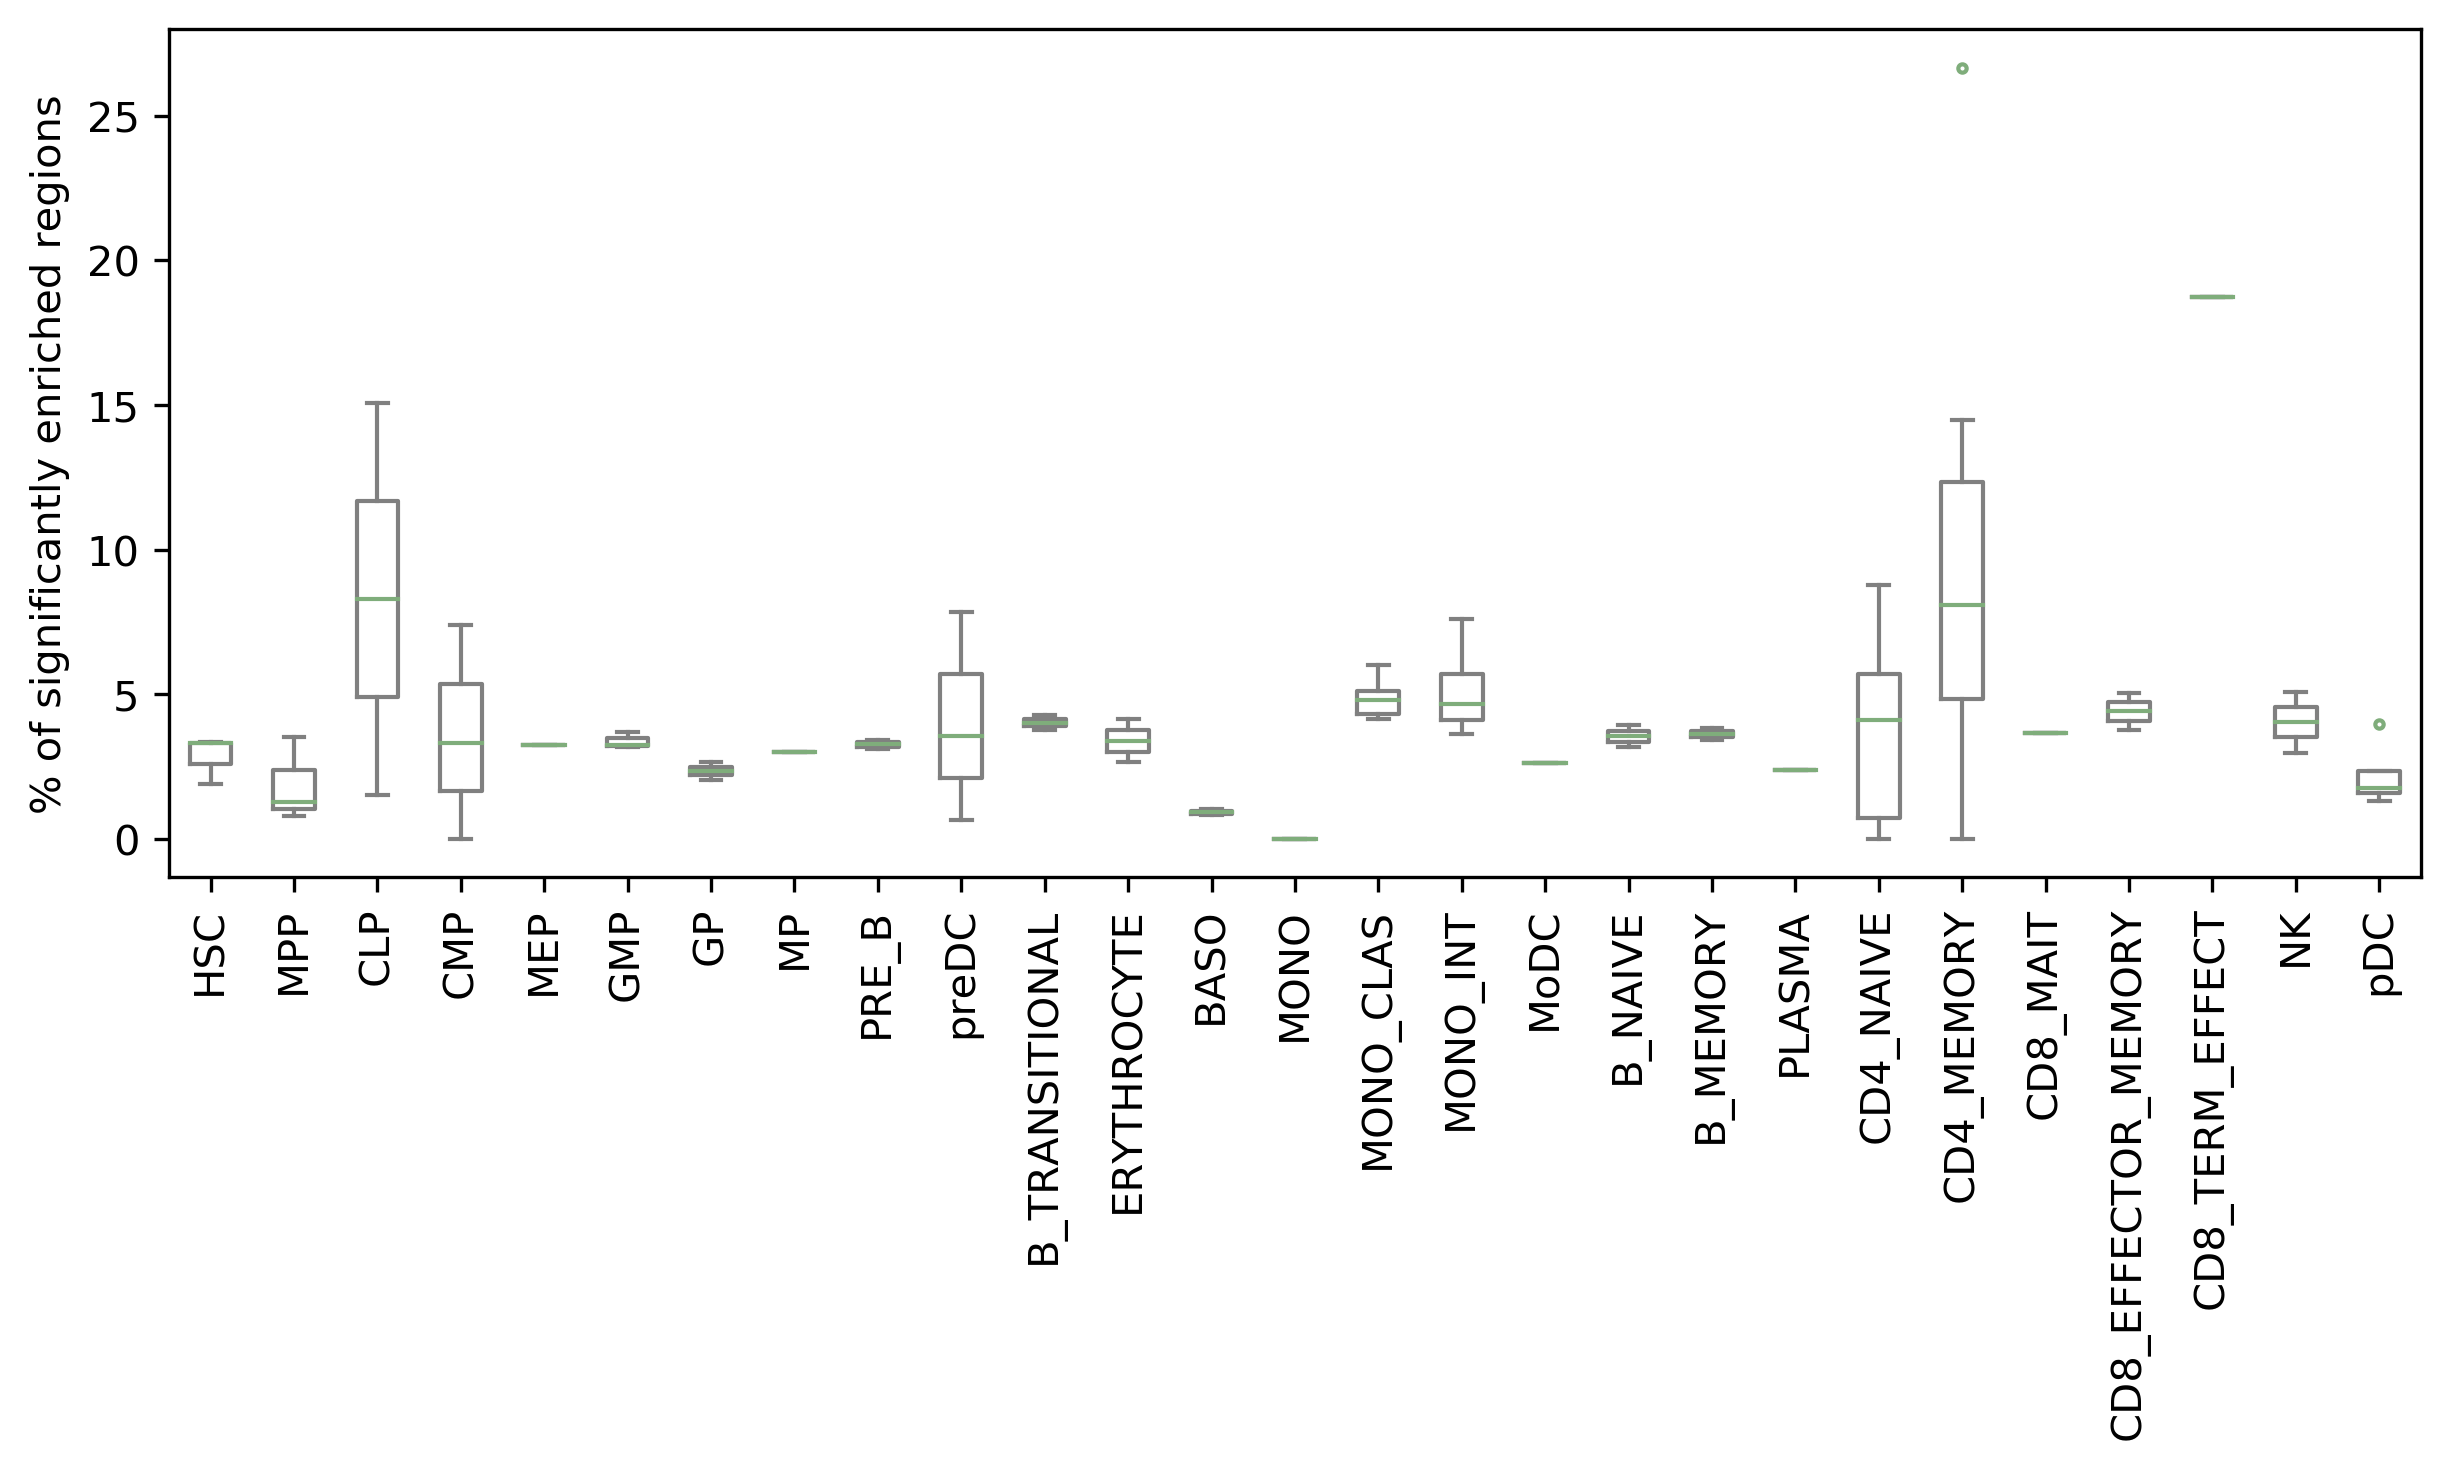

In [37]:
c1 = "#6458ad"
c2 = "#7fad7b"
c3 = "#eca639"
labels, data = pcnt_pos_prom.keys(), pcnt_pos_prom.values()
plt.figure(figsize=(8.27, 5), dpi=300)
box = plt.boxplot(data, flierprops={"markeredgecolor": c2, "markersize": 2})
plt.xticks(range(1, len(labels) + 1), labels, rotation=90)
plt.ylabel("% of significantly enriched regions")
set_box_color(box, c2)
plt.tight_layout()

Visualize the percentage of enhancers per cell annotation

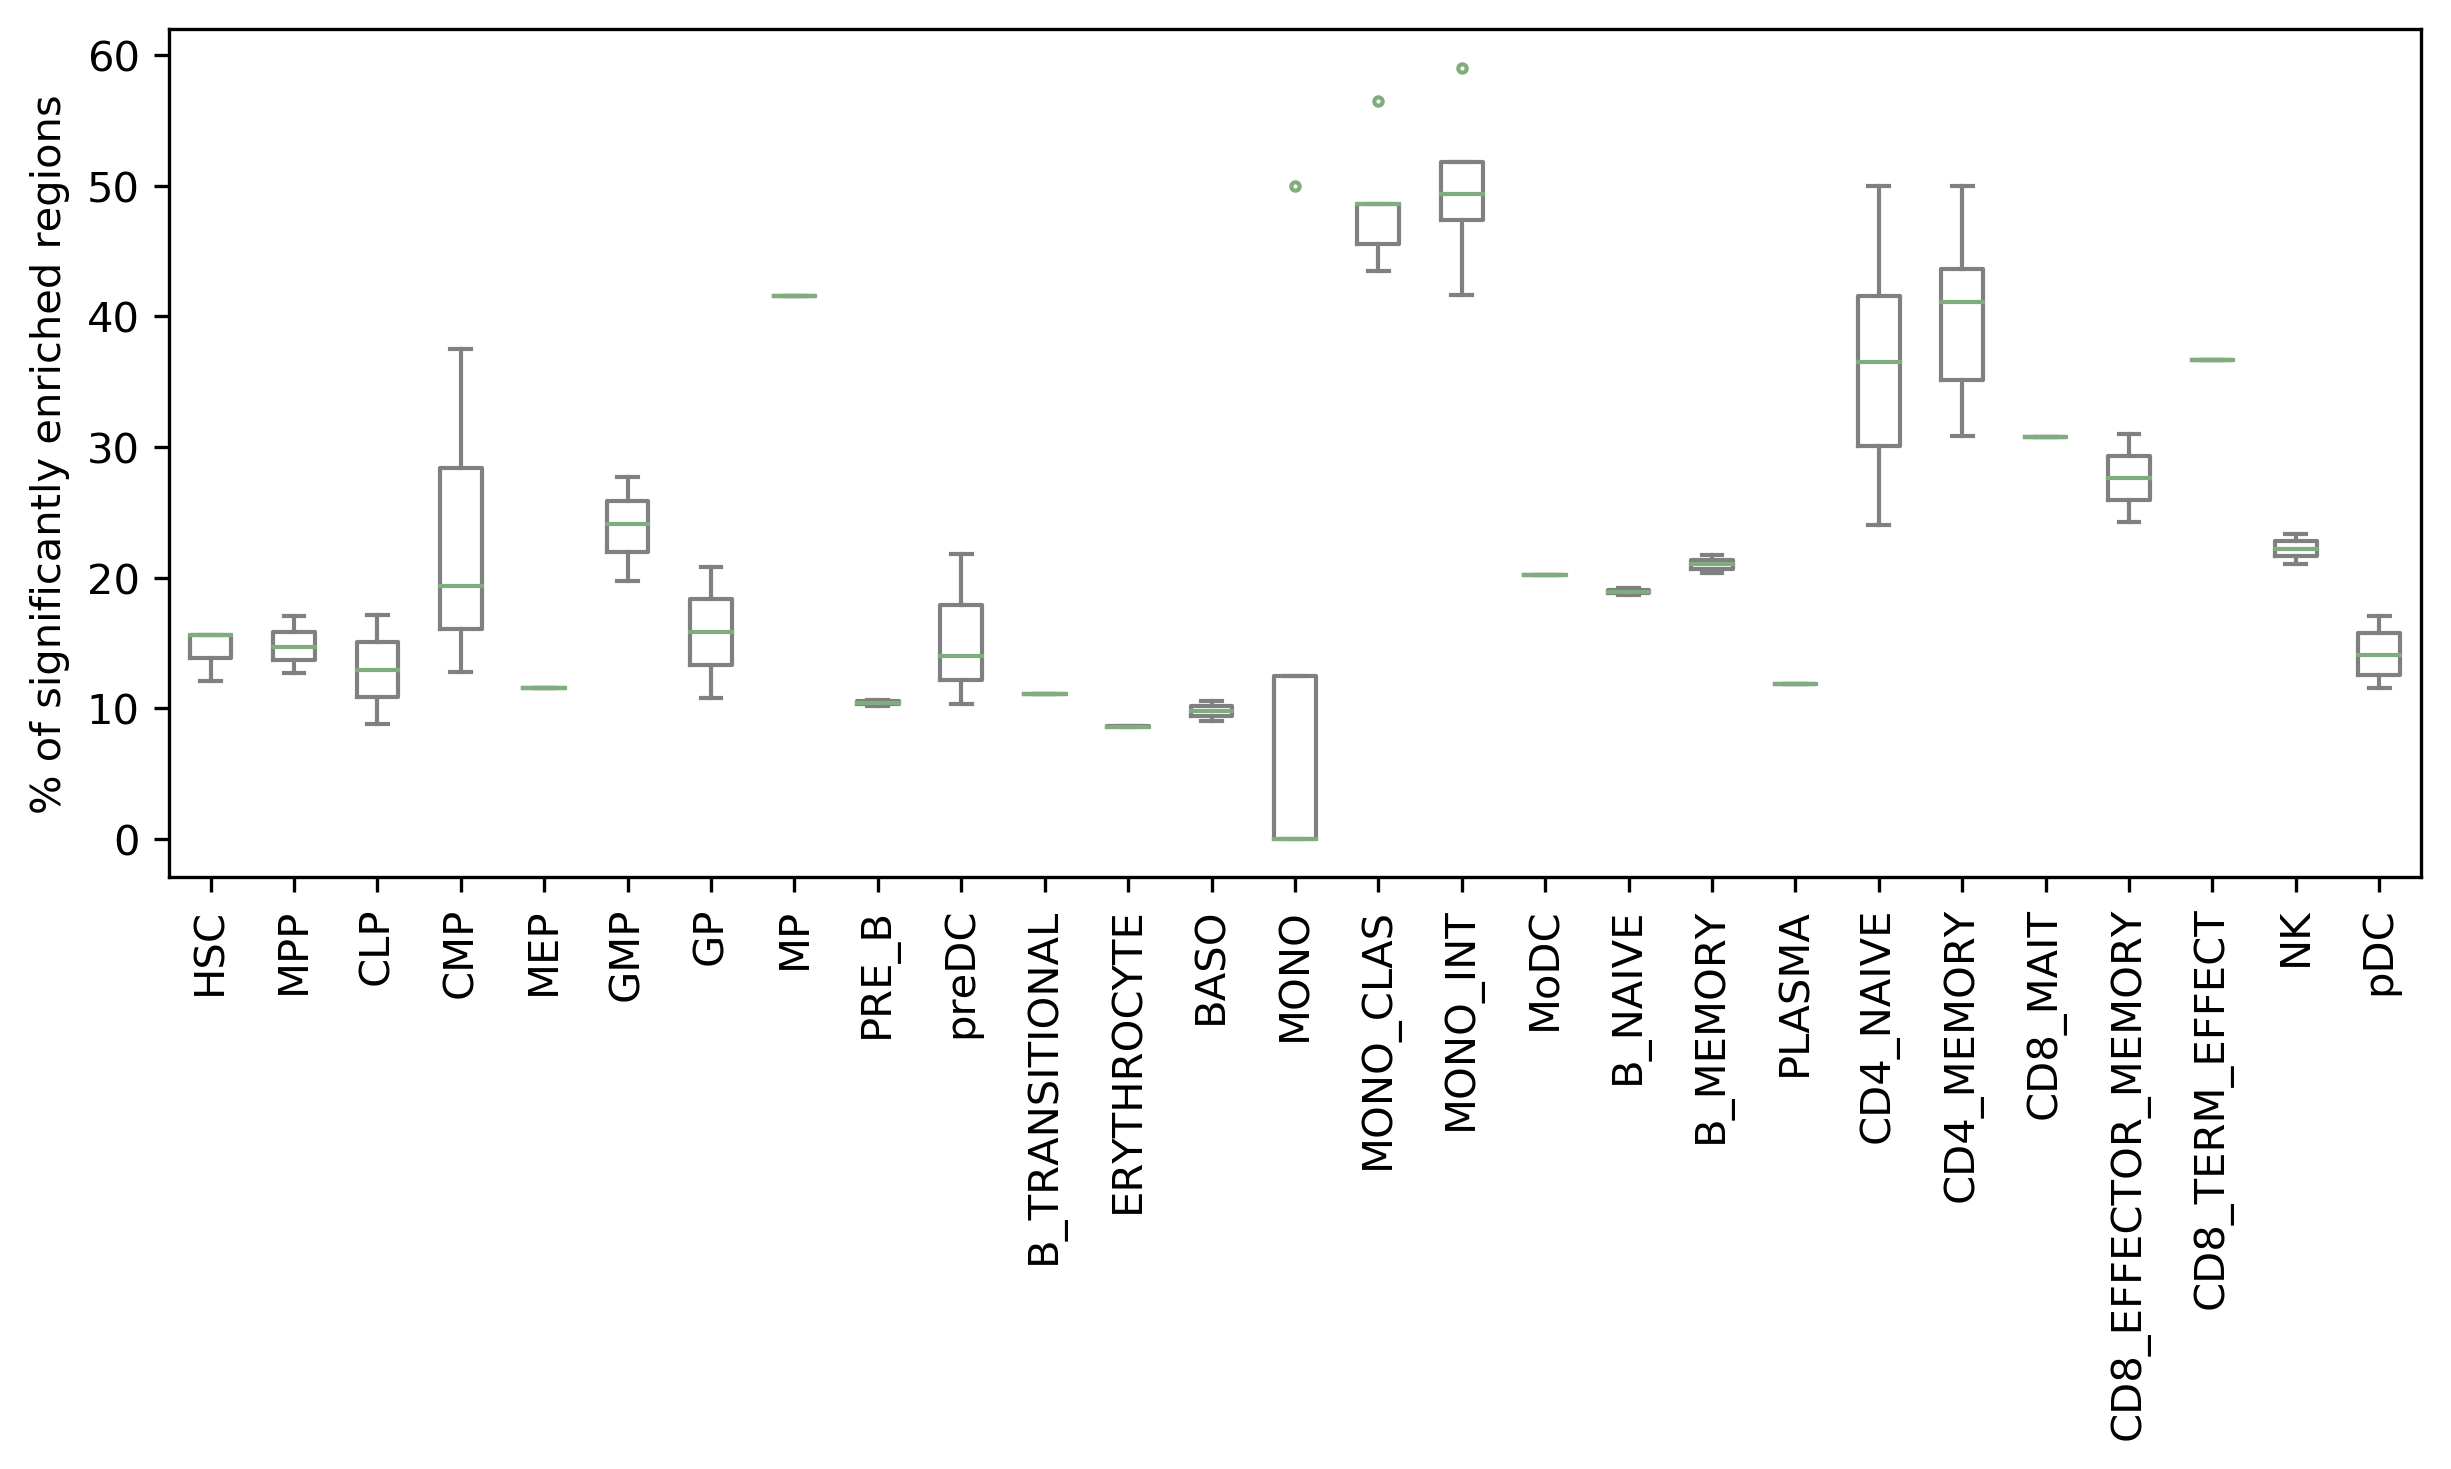

In [38]:
labels, data = pcnt_pos_enh.keys(), pcnt_pos_enh.values()
plt.figure(figsize=(8.27, 5), dpi=300)
box = plt.boxplot(data, flierprops={"markeredgecolor": c2, "markersize": 2})
plt.xticks(range(1, len(labels) + 1), labels, rotation=90)
plt.ylabel("% of significantly enriched regions")
set_box_color(box, c2)
plt.tight_layout()

## 7. Motif enrichment
Since we do not use this downstream, files are not provided, but they can be used to get the files needed for motif enrichment.

In [39]:
homerbed = [p.split("_") for p in peaks]
homerbed = pd.DataFrame(homerbed)
homerbed[4] = range(len(homerbed.index))
homerbed[5] = ""
homerbed[6] = "."
homerbed.to_csv(f"greenleaf_scATAC_motif_background.bed", sep="\t",
                index=None, header=None)

In [40]:
for i, k in enumerate(r_cells, 1):
    i_bed = [p.split("_") for p in sigdict[str(k)]]
    i_bed = pd.DataFrame(i_bed)
    i_bed[4] = range(len(sigdict[str(k)]))
    i_bed[5] = ""
    i_bed[6] = "."
    i_bed.to_csv(f"motifs/greenleaf_scATAC_motif_regions_{i}.bed", sep="\t",
                 index=None, header=None)

In [41]:
with open("motifs/greenleaf_scATAC_ID_mapping.pkl", "wb") as f:
    pickle.dump(dict(enumerate(r_cells)), f)
f.close()